In [187]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import math

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import distance
import os
from sklearn.preprocessing import MinMaxScaler

In [196]:
# Download train.csv.zip from https://www.kaggle.com/competitions/quora-question-pairs/data?select=train.csv.zip
df = pd.read_csv("train.csv")
df_orig = df.copy()

In [124]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [125]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [126]:
df.shape

(404290, 6)

<AxesSubplot:>

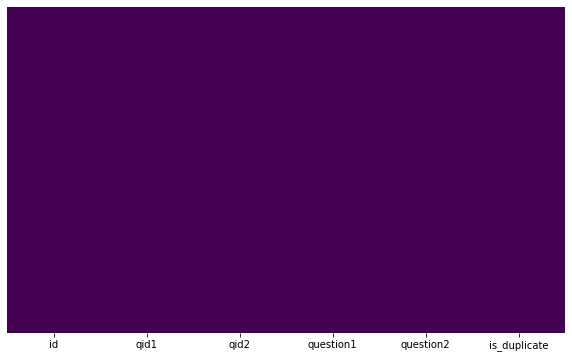

In [127]:
#Check null rows
plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)

<AxesSubplot:xlabel='is_duplicate'>

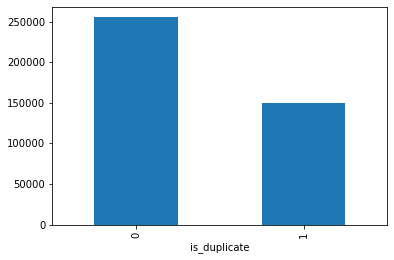

In [128]:
#Check for imbalanced data
df.groupby("is_duplicate")['id'].count().plot.bar()
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [129]:
print("Unique values for each of the columns are :",df.nunique())

Unique values for each of the columns are : id              404290
qid1            290654
qid2            299364
question1       290456
question2       299174
is_duplicate         2
dtype: int64


In [130]:
df_questions = df["question1"].append(df["question2"])
df_questions.nunique()

/var/folders/jw/ll1dqsq57z18kdvpw8n2cc9m0000gn/T/ipykernel_7925/2295982344.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_questions = df["question1"].append(df["question2"])


537360

Total unique questions are less than q1 and q2 combined, it means their are many repeating questions.

In [131]:
questions = {}
count = 1
for ques in df_questions:
    if ques in questions:
        questions[ques] = questions[ques] +1
    else:
        questions[ques] = count  

(array([4.25488e+05, 6.47440e+04, 3.06340e+04, 9.59000e+03, 3.99800e+03,
        1.97900e+03, 7.54000e+02, 1.64000e+02, 7.00000e+00, 3.00000e+00]),
 array([0.        , 0.50814044, 1.01628087, 1.52442131, 2.03256175,
        2.54070218, 3.04884262, 3.55698306, 4.06512349, 4.57326393,
        5.08140436]),
 <BarContainer object of 10 artists>)

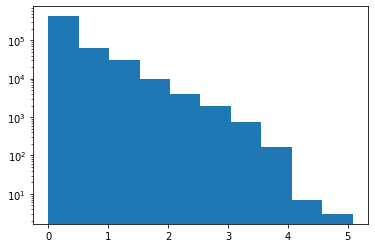

In [132]:
q = []
for ques in questions:
    q.append(questions[ques])

plt.hist(np.log(q), log=True)

Checking for Null Values

In [133]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [134]:
#There are only three records with empty records hence we can delete these
df = df.dropna()

# Now generating few new features
q1len : length of question 1                                                         
q2len : length of question 2                                                        
q1freq, q2freq : frequency of question in the dataset                                                       
q1_n_words : number of words in question 1                                                       
q2_n_words : number of words in question 2                                                           
words share = common words/word total                                                       
freq_q1+q2 = frequency of question 1 + frequency of question 2                                           
req_q1-q2 = absolute difference of question frequencies                                                   



In [135]:
df["q1len"] = df['question1'].str.len() #length of question 1
df["q2len"] = df['question2'].str.len() #length of question 2
df['q1freq'] = df.groupby('qid1')['qid1'].transform('count') 
df['q2freq'] = df.groupby('qid2')['qid2'].transform('count') 

In [136]:
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [137]:
def find_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
df['common_words'] = df.apply(find_common, axis=1)

In [138]:
def count_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1) + len(w2)
df['word_total'] = df.apply(count_total, axis=1)

In [139]:
df['word_share'] = df['common_words']/df['word_total']

In [140]:
df['freq_q1+q2'] = df['q1freq']+df['q2freq']
df['freq_q1-q2'] = abs(df['q1freq']-df['q2freq'])

Analysing extracted features

In [141]:
print("Minimum number of words in questions 1 : ",df['q1_n_words'].min())
print("Minimum number of words in questions 2 : ",df['q2_n_words'].min())
print("Maximum number of words in questions 1 : ",df['q1_n_words'].max())
print("Maximum number of words in questions 2 : ",df['q2_n_words'].max())

Minimum number of words in questions 1 :  1
Minimum number of words in questions 2 :  1
Maximum number of words in questions 1 :  125
Maximum number of words in questions 2 :  237


Feature: word share

/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


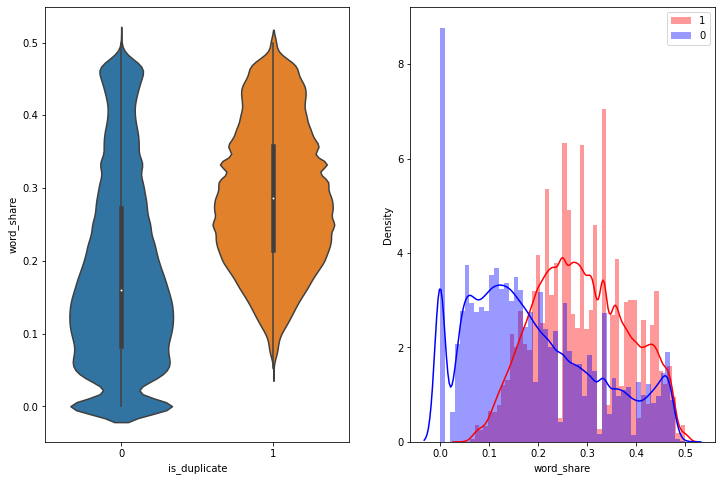

In [142]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

Above plots show that                                                                
If the questions have atleast more than 1 in word share then there are more chances of they being duplicate
If there are zero share                                                                  
words then there are very less chances of being duplicate

/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


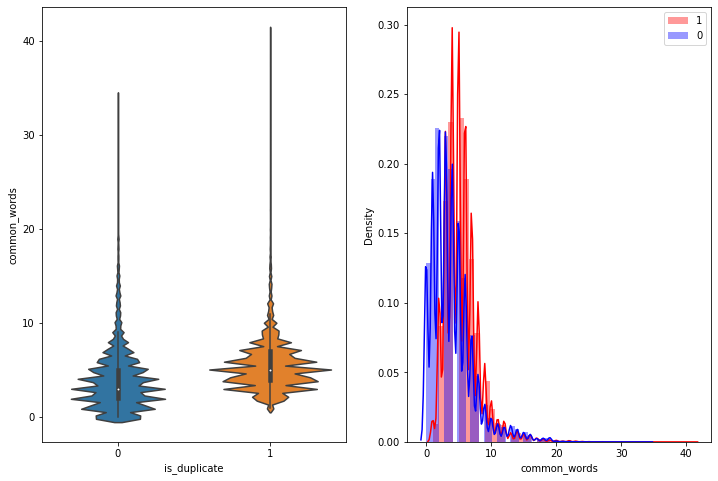

In [143]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_words', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_words'][0:] , label = "0" , color = 'blue' )
plt.legend()
plt.show()

There could not be much inference from common words plots

# EDA after feature extraction

In [144]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1freq,q2freq,q1_n_words,q2_n_words,common_words,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,1,1,14,12,10.0,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,4,1,8,13,4.0,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,1,1,14,10,4.0,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,1,1,11,9,0.0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,3,1,13,7,2.0,20,0.100000,4,2


# Preprocessing text data

In [145]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__  
<br>
<br>

- __fuzz_partial_ratio__ 
<br>
<br>


- __token_sort_ratio__ 
<br>
<br>


- __token_set_ratio__ 
<br>
<br>




- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [146]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
   
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [151]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head()

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1freq,q2freq,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,1,1,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,51,88,4,1,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,1,1,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,50,65,1,1,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,76,39,3,1,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [185]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'q1len',
       'q2len', 'q1freq', 'q2freq', 'q1_n_words', 'q2_n_words', 'common_words',
       'word_total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

<h2> Analysis of New Extracted features </h2>

<h4> Creating words cloud of duplicate and non duplicate question pairs to get insights of most frequent words

In [157]:
df_duplicate = df[df['is_duplicate'] == 1]
df_non_duplicate = df[df['is_duplicate'] == 0]

In [158]:
duplicate_ques = np.dstack((df_duplicate['question1'],df_duplicate['question2'])).flatten()
non_duplicate_ques = np.dstack([df_non_duplicate['question1'],df_non_duplicate['question2']]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(duplicate_ques))
print ("Number of data points in class 0 (non duplicate pairs) :",len(non_duplicate_ques))

#Saving the np array into a text file
np.savetxt('train_p.txt', duplicate_ques, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', non_duplicate_ques, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048


In [159]:
# reading the text files and removing the Stop Words:

textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33192876


Word Cloud for Duplicate Question pairs


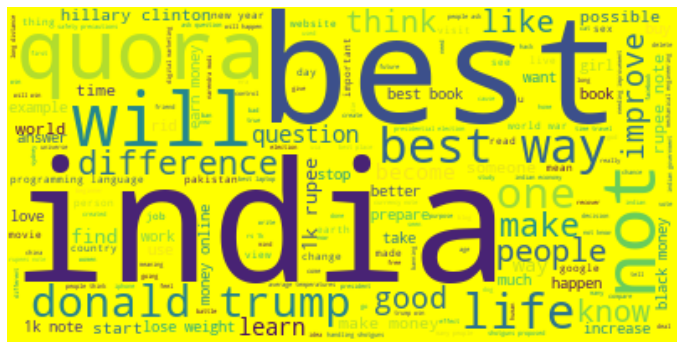

In [176]:
wc = WordCloud(background_color="yellow", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for not Duplicate Question pairs


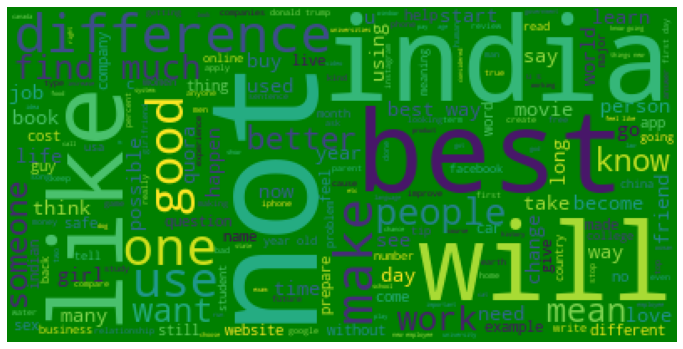

In [177]:
wc = WordCloud(background_color="green", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for not Duplicate Question pairs")
plt.figure(figsize=(12, 8))
plt.imshow(wc)
plt.axis("off")
plt.show()

<h3> Visualizations</h3>

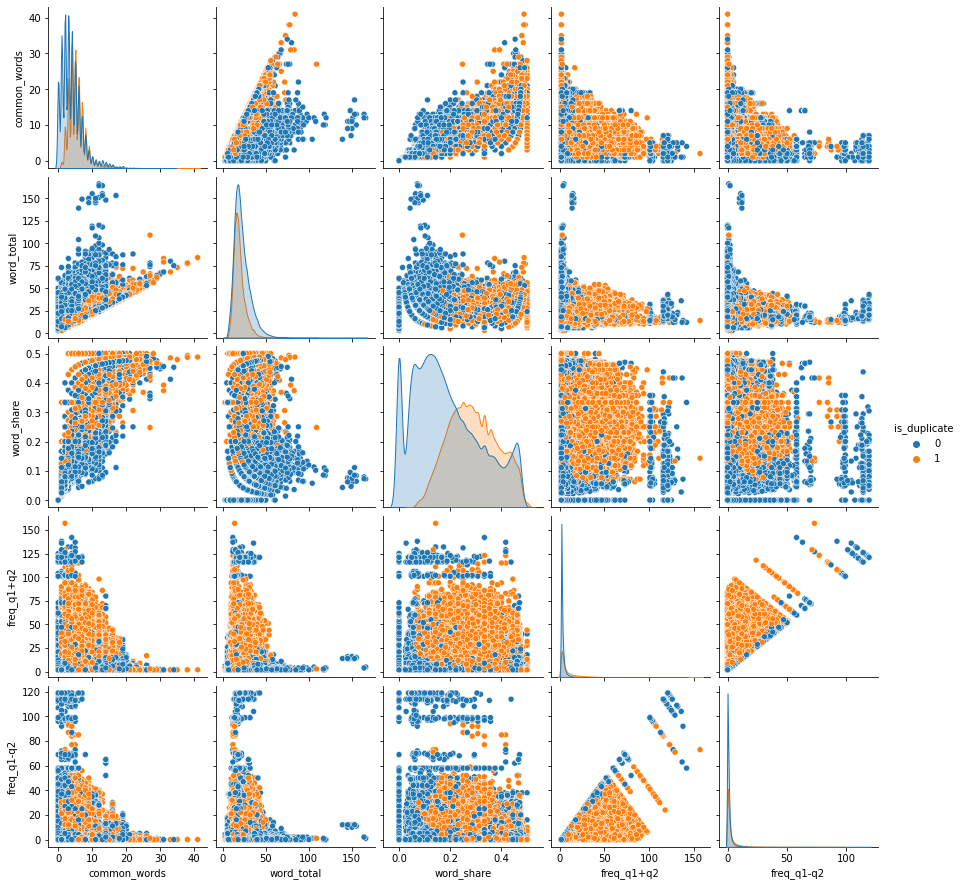

In [179]:
n = df.shape[0]
sns.pairplot(df[['common_words', 'word_total', 'word_share', 'freq_q1+q2','freq_q1-q2', 'is_duplicate']][0:n], hue='is_duplicate', vars=['common_words', 'word_total', 'word_share', 'freq_q1+q2','freq_q1-q2'])
plt.show()


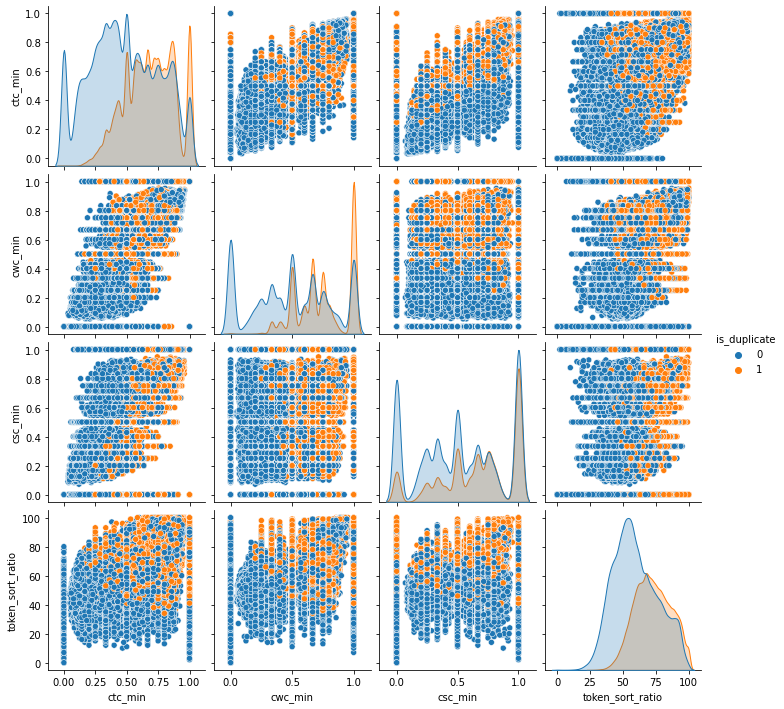

In [178]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


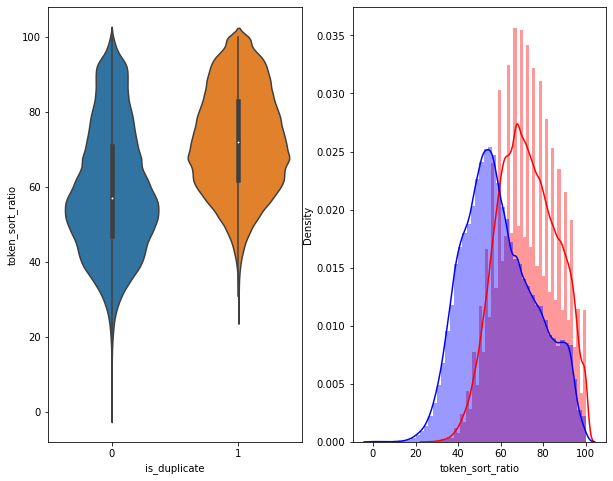

In [180]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


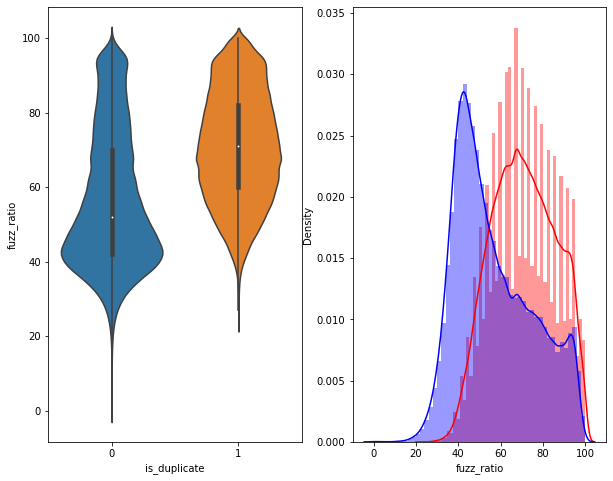

In [181]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3> Applying tsne for dimension reduction visualization</h3>

In [188]:
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[[ 'q1len',
       'q2len', 'q1freq', 'q2freq', 'q1_n_words', 'q2_n_words', 'common_words',
       'word_total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [189]:
tsne2d = TSNE(
    n_components=2,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.602s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.145874
[t-SNE] Computed conditional probabilities in 0.134s
[t-SNE] Iteration 50: error = 81.5199738, gradient norm = 0.0493840 (50 iterations in 0.712s)
[t-SNE] Iteration 100: error = 71.0275116, gradient norm = 0.0099071 (50 iterations in 0.477s)
[t-SNE] Iteration 150: error = 69.3946609, gradient norm = 0.0054162 (50 iterations in 0.449s)
[t-SNE] Iteration 200: error = 68.6808777, gradient norm = 0.0045731 (50 iterations in 0.433s)
[t-SNE] Iteration 250: error = 68.2648010, gradient norm = 0.0047987

/Users/ekanshpruthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


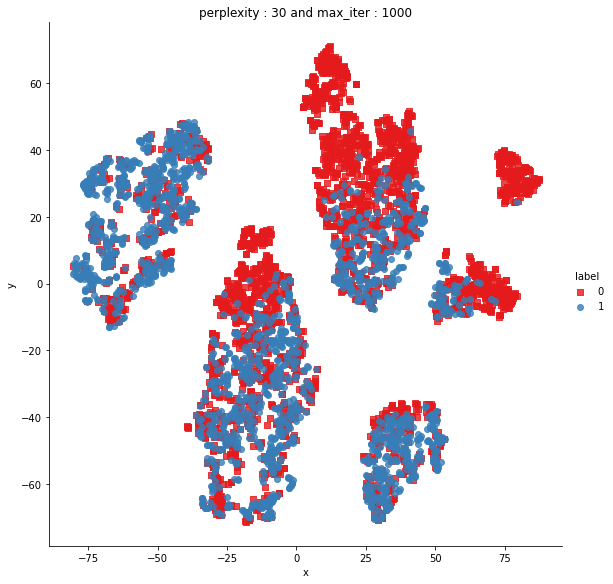

In [190]:
df_t = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_t, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

<h4> There is no clear sepration of data in lower dimension so we won't go for this data dimension reduction technique</h4>